In [39]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import hp
from sklearn.metrics import mean_squared_error, mean_poisson_deviance
from base64 import b64decode, b64encode
from io import BytesIO
from PIL import Image
import shap
import seaborn as sns
from scipy.stats import gmean, rankdata




from insolver.wrappers import InsolverGLMWrapper, InsolverGBMWrapper
from insolver import InsolverDataFrame
from insolver.transforms import InsolverTransform

In [2]:
%%time

train_data = pd.read_csv('./data/train.csv',index_col=0)
train_data.head()

Wall time: 2.15 s


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
id,,,,,,,,,,,,,,,,,,,,,
0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,1.09101,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,1.28138,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,1.24210,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,1.09130,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,1.10151,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197,1


In [3]:
%%time

test_data = pd.read_csv('./data/test.csv',index_col=0)
test_data.head()

Wall time: 1.18 s


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,
250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.04360,0.942256,29.898000,1.11394,...,0.446389,-422.332,-1.44630,1.69075,1.059300,-3.010570,1.94664,0.529470,1.386950,8.78767
250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.80500,0.807194,38.421900,1.09695,...,0.377179,10352.200,21.06270,1.84351,0.251895,4.440570,1.90309,0.248534,0.863881,11.79390
250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.24000,-0.003300,37.940000,1.15222,...,0.990140,3224.020,-2.25287,1.55100,-0.559157,17.838600,1.83385,0.931796,2.336870,9.05400
250003,0.860985,19,-0.549509,0.471799,7501.6000,2.80698,71.08170,0.792136,0.395235,1.20157,...,1.396880,9689.760,14.77150,1.41390,0.329272,0.802437,2.23251,0.893348,1.359470,4.84833
250004,0.313229,89,0.588509,0.167705,2931.2600,4.34986,1.57187,1.118300,7.754630,1.16807,...,0.862502,2693.350,44.18050,1.58020,-0.191021,26.253000,2.68238,0.361923,1.532800,3.70660


In [4]:
target = ['loss']

In [5]:
InsTransforms = InsolverTransform(train_data, [])

In [6]:
train, valid, test = InsTransforms.split_frame(val_size=0.2, test_size=0.2, random_state=43, shuffle=True)

In [7]:
features = train.drop('loss', axis=1).columns.to_list()

In [8]:
x_train, x_valid, x_test = train[features], valid[features], test[features]
y_train, y_valid, y_test = train[target], valid[target], test[target]

In [9]:
igbm = InsolverGBMWrapper(backend='lightgbm', task='reg', objective='regression',
                          boosting_type='gbdt')

In [10]:
space_lightgbm = {'n_estimators':hp.quniform('n_estimators', 500, 1500, 25),
                  "max_depth": hp.quniform('max_depth', 3, 7, 1),
                  "min_child_weight": hp.quniform('min_child_weight', 0, 50, 4),
                  "subsample": hp.uniform('subsample', 0.5, 1),
                  "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1),
                  "alpha": hp.uniform('alpha', 0, 1),
                  "num_leaves": hp.quniform('num_leaves', 31, 250, 5),
                  "reg_lambda": hp.uniform('reg_lambda', 0, 1),                   
                  "learning_rate": hp.uniform('learning_rate', 0.01, 1),
                  "n_jobs":-1}
igbm.hyperopt_cv(x_train, y_train, space_lightgbm, max_evals=100, timeout=3600 * 3,
                 fn_params={'n_jobs':-1, 'scoring': mean_squared_error })

100%|███████████████████████████████████████████████| 100/100 [08:56<00:00,  5.36s/trial, best loss: 61.95196608305797]


{'alpha': 0.571960876504497,
 'colsample_bytree': 0.6541729174641888,
 'learning_rate': 0.22766647188276765,
 'max_depth': 3,
 'min_child_weight': 0,
 'n_estimators': 1050,
 'n_jobs': -1,
 'num_leaves': 75,
 'reg_lambda': 0.3869966369401152,
 'subsample': 0.5482600715517738}

In [11]:
y_pred = igbm.predict(x_valid)
mean_squared_error(y_valid, y_pred, squared=False)

7.873100848644629

In [12]:
pred = igbm.predict(test_data)
pred

array([8.05991424, 5.38520321, 8.14268412, ..., 6.70010756, 5.4278013 ,
       7.01611744])

In [13]:
shap_values=igbm.shap(x_train)

In [14]:
features_after_shap = []
for feat in shap_values:
    if shap_values[feat] != 0:
        features_after_shap.append(feat)
features_after_shap = features_after_shap[1:]

In [15]:
x_train, x_valid, x_test = train[features_after_shap], valid[features_after_shap], test[features_after_shap]
y_train, y_valid, y_test = train[target], valid[target], test[target]

In [16]:
igbm.hyperopt_cv(x_train, y_train, space_lightgbm, max_evals=100, timeout=3600 * 3,
                 fn_params={'n_jobs':-1, 'scoring': mean_squared_error })

100%|████████████████████████████████████████████████| 100/100 [08:34<00:00,  5.15s/trial, best loss: 61.9384289144693]


{'alpha': 0.6548734678045336,
 'colsample_bytree': 0.7139415276633512,
 'learning_rate': 0.25255662062584433,
 'max_depth': 3,
 'min_child_weight': 12,
 'n_estimators': 1275,
 'n_jobs': -1,
 'num_leaves': 175,
 'reg_lambda': 0.4812507680028024,
 'subsample': 0.7468261852599043}

In [17]:
y_pred = igbm.predict(x_valid)
mean_squared_error(y_valid, y_pred, squared=False)

7.873085653251558

In [18]:
pred_lgnm = igbm.predict(test_data)
pred_lgnm

array([7.97549832, 5.10576576, 7.99419012, ..., 6.8187059 , 5.40896493,
       6.71588038])

In [19]:
igbm = InsolverGBMWrapper(backend='catboost', task='reg', objective='RMSE',
                          boosting_type='Plain')

In [20]:
space_catboost ={'depth': hp.quniform('depth', 2, 5, 1),
                 'n_estimators': hp.quniform('n_estimators', 500, 2000, 250),
                 'max_bin' : hp.quniform('max_bin', 1, 32, 1),
                 'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 5),
                 'thread_count':-1,
                 'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
                 'learning_rate' : hp.uniform('learning_rate', 0.01, 1),}
igbm.hyperopt_cv(x_train, y_train, space_catboost, max_evals=100, timeout=3600 * 3,
                 fn_params={'n_jobs':-1, 'scoring': mean_squared_error })

100%|███████████████████████████████████████████████| 100/100 [11:42<00:00,  7.03s/trial, best loss: 62.08421415385091]
0:	learn: 7.9328793	total: 173ms	remaining: 17.1s
1:	learn: 7.9299676	total: 182ms	remaining: 8.93s
2:	learn: 7.9263232	total: 193ms	remaining: 6.25s
3:	learn: 7.9244477	total: 204ms	remaining: 4.89s
4:	learn: 7.9214521	total: 214ms	remaining: 4.07s
5:	learn: 7.9196501	total: 225ms	remaining: 3.53s
6:	learn: 7.9176778	total: 234ms	remaining: 3.11s
7:	learn: 7.9161264	total: 245ms	remaining: 2.81s
8:	learn: 7.9145116	total: 255ms	remaining: 2.58s
9:	learn: 7.9129533	total: 264ms	remaining: 2.37s
10:	learn: 7.9116921	total: 273ms	remaining: 2.21s
11:	learn: 7.9101526	total: 284ms	remaining: 2.08s
12:	learn: 7.9087645	total: 294ms	remaining: 1.97s
13:	learn: 7.9076276	total: 304ms	remaining: 1.86s
14:	learn: 7.9062862	total: 313ms	remaining: 1.77s
15:	learn: 7.9049894	total: 323ms	remaining: 1.69s
16:	learn: 7.9035443	total: 333ms	remaining: 1.63s
17:	learn: 7.9027051	to

{'depth': 2,
 'l2_leaf_reg': 3.8793828437426803,
 'learning_rate': 0.4524736930213267,
 'max_bin': 25,
 'min_data_in_leaf': 36,
 'n_estimators': 1000,
 'thread_count': -1}

In [21]:
pred_catboost = igbm.predict(test_data)
pred_catboost

array([7.48317263, 5.0733629 , 7.39350065, ..., 6.87206519, 6.03007092,
       6.45512104])

In [29]:
igbm = InsolverGBMWrapper(backend='xgboost', task='reg', objective='reg:squarederror',
                          boosting_type='hist ')

In [31]:
space_xgboost =space ={
                    "n_estimators": hp.quniform('n_estimators', 100, 500, 50),
                    'max_depth': hp.quniform('max_depth', 3, 5, 1),
                    'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                    'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                    'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 1),
                    'subsample' : hp.uniform('subsample', 0.5, 1),
                    'nthread' : -1
            }
igbm.hyperopt_cv(x_train, y_train, space_xgboost, max_evals=20, timeout=3600 * 3,
                 fn_params={'n_jobs':-1, 'scoring': mean_squared_error })

100%|█████████████████████████████████████████████████| 20/20 [24:51<00:00, 74.58s/trial, best loss: 61.99477359439228]
[17:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'learning_rate': 0.1446293595462582,
 'max_depth': 4,
 'min_child_weight': 0.5861549166370633,
 'n_estimators': 150,
 'nthread': -1,
 'reg_alpha': 4.387112539059847,
 'reg_lambda': 3.499560918881217,
 'subsample': 0.7818291529401805}

In [32]:
pred_xgboost = igbm.predict(test_data)
pred_xgboost

array([9.114384 , 5.55569  , 6.923945 , ..., 6.4297094, 5.1513863,
       7.0227575], dtype=float32)

In [62]:
scores = pd.DataFrame({
    "pred_lgnm": pred_lgnm,
    "pred_xgboost": pred_xgboost,
    "pred_catboost": pred_catboost
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

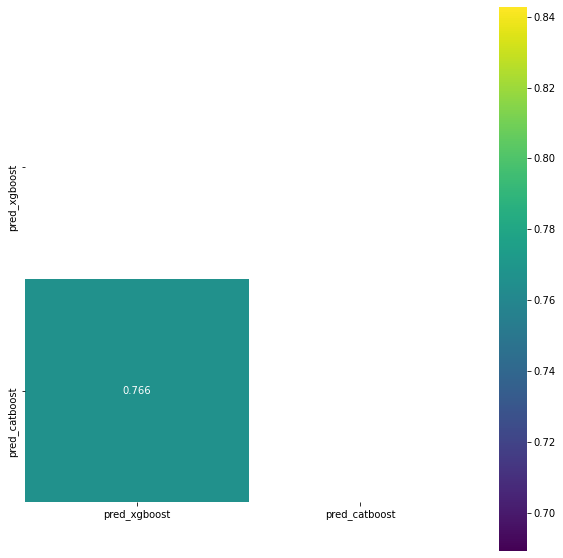

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [64]:
scores_mean = scores.mean(axis=1)
score = mean_squared_error(train['loss'], scores_mean, squared=False)
print(f"Score = {round(score, 5)}")

Score = 7.98513


In [65]:
scores_mean = gmean(scores, axis=1)
score = mean_squared_error(train['loss'], scores_mean, squared=False)
print(f"Score = {round(score, 5)}")

Score = 7.98492


In [66]:
scores_mean = gmean(scores, axis=1)

In [67]:
scores_mean

array([8.25860198, 5.30905176, 7.15487187, ..., 6.64720862, 5.5734392 ,
       6.73295996])

In [68]:
len(pred)

150000

In [69]:
preds_final = pd.DataFrame()
preds_final['id']  = test_data.index.copy()
preds_final['loss'] = scores_mean

In [70]:
preds_final.to_csv('insolver.csv', index=False)